# MATH 582 Mini Project 4 - Group 1

In [29]:
from copy import deepcopy
import numpy as np
import pandas as pd
from numpy.random import multivariate_normal
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from sklearn.metrics import mean_squared_error
from math import sqrt

%matplotlib inline
np.random.seed(333)

## Lorenz '63 System of Equations

Below, we define the differential equations that comprise the Lorenz '63 system.

In [30]:
# Define the Lorenz '63 system of differential equations

# constants
sigma=10.
beta=8./3.
rho=28.

# derivative functions
def dxdt(x, y, z, t):
    return sigma * (y - x)

def dydt(x, y, z, t):
    return x * (rho - z) - y

def dzdt(x, y, z, t):
    return x * y - beta * z

lorenz_derivs = [dxdt, dydt, dzdt]

In [31]:
# Define the Runge-Kutta order 4 solver

def rk4(state, derivs, t, dt):
    x = list(state)

    args = x + [t]
    k1 = [ dt * f(*args) for f in derivs ]

    args = [ r+0.5*kr for r,kr in zip(x + [t], k1 + [dt]) ]
    k2 = [ dt * f(*args) for f in derivs ]

    args = [ r+0.5*kr for r,kr in zip(x + [t], k2 + [dt]) ]
    k3 = [ dt * f(*args) for f in derivs ]

    args = [ r+kr for r,kr in zip(x + [t], k3 + [dt]) ]
    k4 = [ dt * f(*args) for f in derivs ]

    return np.array( [r+(k1r+2*k2r+2*k3r+k4r)/6 for r,k1r,k2r,k3r,k4r in zip(x,k1,k2,k3,k4)] )

In [32]:
# Given a state (x, y, z) and a time step size dt, predict the next state of the system

def lorenz_step(state, dt):
    return rk4(state, lorenz_derivs, 0, dt)

In [33]:
def simulate_lorenz_ideal(state, t0, tFinal, dt):
    x0, y0, z0 = state
    steps = int(np.floor((tFinal-t0) / dt))

    t = steps * [0.0]
    x = steps * [0.0]
    y = steps * [0.0]
    z = steps * [0.0]

    x[0],y[0],z[0],t[0] = x0, y0, z0, t0  #Initial system state

    for i in range(1, steps):
        x[i],y[i],z[i] = lorenz_step( (x[i-1],y[i-1],z[i-1]) , dt)

    return x, y, z, t

In [34]:
x0, y0, z0, t0, tFinal, dt = 1., 1., 1., 0., 40., 0.01

x, y, z, t = simulate_lorenz_ideal( (x0, y0, z0) , t0, tFinal, dt)

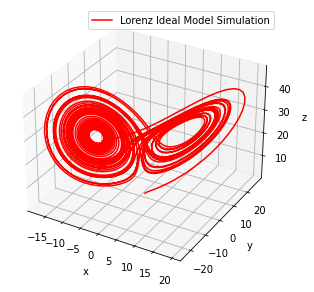

In [35]:
def plot_3d(x, y, z, title):
    fig = plt.figure()
    fig.set_figwidth(10)
    fig.set_figheight(5)
    ax = fig.add_subplot(projection='3d')
    ax.plot(x,y,z,'r',label=title)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.legend()
    plt.show()

plot_3d(x,y,z,'Lorenz Ideal Model Simulation')

In [36]:
def generate_lorenz_data(state, t0, tFinal, dt, q_truth, q_measurement):
    x0, y0, z0 = state
    D = 3
    steps = int(np.floor((tFinal-t0) / dt))

    # noise matrices:
    # Q_truth: The random variation matrix introduced to perturb the ideal model (for the purposes of generating data)
    # Q_measurement: The sampling error matrix of the fictional measurement device
    Q_truth = q_truth * np.eye(D)
    Q_measurement = q_measurement * np.eye(D)

    t = np.zeros(steps)

    # each row is a state vector (x,y,z)
    # X[i] returns the state of step i
    X_ideal = np.zeros((steps, D)) # the ideal system state (no variation introduced)
    X_theoretical = np.zeros((steps, D)) # the ideal system state for a given step, based on previous X_truth
    X_truth = np.zeros((steps, D)) # the true system state (Gaussian random variable with mean of X_theoretical at each step)
    X_measurement = np.zeros((steps, D)) # the noisy measurement at each step (Gaussian random variable with mean of X_truth at each step)

    # initialize system state
    t[0] = t0
    X_ideal[0] = np.array(state)
    X_theoretical[0] = np.array(state)
    X_truth[0] = np.array(state)
    X_measurement[0] = np.array(state)

    for k in range(1, steps):
        t[k] = k * dt
        X_ideal[k] = lorenz_step(X_ideal[k-1], dt)
        X_theoretical[k] = lorenz_step(X_truth[k-1], dt)
        X_truth[k] = multivariate_normal(X_theoretical[k], Q_truth)
        X_measurement[k] = multivariate_normal(X_truth[k], Q_measurement)

    return t, X_ideal, X_theoretical, X_truth, X_measurement
    

In [37]:
q_truth = 0.01
q_measurement = 0.01
t, X_ideal, X_theoretical, X_truth, X_measurement = generate_lorenz_data( (x0, y0, z0), t0, tFinal, dt, q_truth, q_measurement)
X_measurement

array([[  1.        ,   1.        ,   1.        ],
       [  1.17049379,   1.34488109,   0.90165305],
       [  1.0147638 ,   1.53183106,   0.96753221],
       ...,
       [-14.28176372, -17.94071172,  30.4384899 ],
       [-14.659465  , -17.28275251,  32.22067827],
       [-14.6891497 , -16.53660952,  33.77178351]])

In [38]:
# Helper functions for EnsembleKalmanFilter class

def pretty_str(label, arr):
    """
    Generates a pretty printed NumPy array with an assignment. Optionally
    transposes column vectors so they are drawn on one line.
    Examples
    --------
    >>> pprint('cov', np.array([[4., .1], [.1, 5]]))
    cov = [[4.  0.1]
           [0.1 5. ]]
    >>> print(pretty_str('x', np.array([[1], [2], [3]])))
    x = [[1 2 3]].T
    """

    def is_col(a):
        """ return true if a is a column vector"""
        try:
            return a.shape[0] > 1 and a.shape[1] == 1
        except (AttributeError, IndexError):
            return False

    if label is None:
        label = ''

    if label:
        label += ' = '

    if is_col(arr):
        return label + str(arr.T).replace('\n', '') + '.T'

    rows = str(arr).split('\n')
    if not rows:
        return ''

    s = label + rows[0]
    pad = ' ' * len(label)
    for line in rows[1:]:
        s = s + '\n' + pad + line

    return s

def outer_product_sum(A, B):
    """
    Computes the sum of the outer products of the rows in A and B.
    Parameters
    ----------
    A : np.array, shape (M, N)
        rows of N-vectors to have the outer product summed
    B : np.array, shape (M, N)
        rows of N-vectors to have the outer product summed
        If it is `None`, it is set to A.
    """
    if B is None:
            B = A

    outer = np.einsum('ij,ik->ijk', A, B)
    return np.sum(outer, axis=0)

## Defining the Ensemble Kalman Filter (EnKF) Class

In the cell below, we define a class that implements the functionality of the Ensemble Kalman filter. This class exposes the methods predict() and update(). The predict() method predicts the next time step. The update() method updates the model with an observation at a given time step.

In [39]:
class EnsembleKalmanFilter(object):
    """
    This implements the ensemble Kalman filter (EnKF).
    Parameters
    ----------
    x : np.array(dim_x)
        state mean
    P : np.array((dim_x, dim_x))
        covariance of the state
    dim_z : int
        Number of of measurement inputs. For example, if the sensor
        provides you with position in (x,y), dim_z would be 2.
    dt : float
        time step in seconds
    N : int
        number of sigma points (ensembles). Must be greater than 1.
    K : np.array
        Kalman gain
    hx : function hx(x)
        Measurement function. May be linear or nonlinear - converts state
        x into a measurement. Return must be an np.array of the same
        dimensionality as the measurement vector.
    fx : function fx(x, dt)
        State transition function. May be linear or nonlinear. Projects
        state x into the next time period. Returns the projected state x.
    Attributes
    ----------
    x : numpy.array(dim_x, 1)
        State estimate
    P : numpy.array(dim_x, dim_x)
        State covariance matrix
    x_prior : numpy.array(dim_x, 1)
        Prior (predicted) state estimate. The *_prior and *_post attributes
        are for convienence; they store the  prior and posterior of the
        current epoch. Read Only.
    P_prior : numpy.array(dim_x, dim_x)
        Prior (predicted) state covariance matrix. Read Only.
    x_post : numpy.array(dim_x, 1)
        Posterior (updated) state estimate. Read Only.
    P_post : numpy.array(dim_x, dim_x)
        Posterior (updated) state covariance matrix. Read Only.
    z : numpy.array
        Last measurement used in update(). Read only.
    R : numpy.array(dim_z, dim_z)
        Measurement noise matrix
    Q : numpy.array(dim_x, dim_x)
        Process noise matrix
    fx : callable (x, dt)
        State transition function
    hx : callable (x)
        Measurement function. Convert state `x` into a measurement
    K : numpy.array(dim_x, dim_z)
        Kalman gain of the update step. Read only.
    inv : function, default numpy.linalg.inv
        If you prefer another inverse function, such as the Moore-Penrose
        pseudo inverse, set it to that instead: kf.inv = np.linalg.pinv
    Examples
    --------
    .. code-block:: Python
        def hx(x):
           return np.array([x[0]])
        F = np.array([[1., 1.],
                      [0., 1.]])
        def fx(x, dt):
            return np.dot(F, x)
        x = np.array([0., 1.])
        P = np.eye(2) * 100.
        dt = 0.1
        f = EnsembleKalmanFilter(x=x, P=P, dim_z=1, dt=dt,
                                 N=8, hx=hx, fx=fx)
        std_noise = 3.
        f.R *= std_noise**2
        f.Q = Q_discrete_white_noise(2, dt, .01)
        while True:
            z = read_sensor()
            f.predict()
            f.update(np.asarray([z]))

    Reference: https://github.com/rlabbe/filterpy/blob/master/filterpy/kalman/ensemble_kalman_filter.py
    """

    def __init__(self, x, P, dim_z, dt, N, hx, fx):
        if dim_z <= 0:
            raise ValueError('dim_z must be greater than zero')

        if N <= 0:
            raise ValueError('N must be greater than zero')

        dim_x = len(x)
        self.dim_x = dim_x
        self.dim_z = dim_z
        self.dt = dt
        self.N = N
        self.hx = hx
        self.fx = fx
        self.K = np.zeros((dim_x, dim_z))
        self.z = np.array([[None] * self.dim_z]).T
        self.S = np.zeros((dim_z, dim_z))   # system uncertainty
        self.SI = np.zeros((dim_z, dim_z))  # inverse system uncertainty
        self.step = 0

        self.initialize(x, P)
        self.Q = np.eye(dim_x)       # process uncertainty
        self.R = np.eye(dim_z)       # state uncertainty
        self.inv = np.linalg.inv

        # used to create error terms centered at 0 mean for
        # state and measurement
        self._mean = np.zeros(dim_x)
        self._mean_z = np.zeros(dim_z)

    def initialize(self, x, P):
        """
        Initializes the filter with the specified mean and
        covariance. Only need to call this if you are using the filter
        to filter more than one set of data; this is called by __init__
        Parameters
        ----------
        x : np.array(dim_z)
            state mean
        P : np.array((dim_x, dim_x))
            covariance of the state
        """

        if x.ndim != 1:
            raise ValueError('x must be a 1D array')

        self.sigmas = multivariate_normal(mean=x, cov=P, size=self.N)
        self.x = x
        self.P = P

        # these will always be a copy of x,P after predict() is called
        self.x_prior = self.x.copy()
        self.P_prior = self.P.copy()

        # these will always be a copy of x,P after update() is called
        self.x_post = self.x.copy()
        self.P_post = self.P.copy()

    def time(self): # returns the current "time" of the system
        return self.step * self.dt

    def update(self, z, R=None): # Peforms data assimilation on a measurement and predicts next step
        """
        Add a new measurement (z) to the kalman filter. If z is None, nothing
        is changed.
        Parameters
        ----------
        z : np.array
            measurement for this update.
        R : np.array, scalar, or None
            Optionally provide R to override the measurement noise for this
            one call, otherwise self.R will be used.
        """

        if z is None:
            self.z = np.array([[None]*self.dim_z]).T
            self.x_post = self.x.copy()
            self.P_post = self.P.copy()
            return

        if R is None:
            R = self.R
        if np.isscalar(R):
            R = np.eye(self.dim_z) * R

        N = self.N
        dim_z = len(z)
        sigmas_h = np.zeros((N, dim_z))

        # transform sigma points into measurement space
        for i in range(N):
            sigmas_h[i] = self.hx(self.sigmas[i])

        z_mean = np.mean(sigmas_h, axis=0)

        P_zz = (outer_product_sum(sigmas_h - z_mean, sigmas_h - z_mean) / (N-1)) + R
        P_xz = outer_product_sum(self.sigmas - self.x, sigmas_h - z_mean) / (N - 1)

        self.S = P_zz
        self.SI = self.inv(self.S)
        self.K = np.dot(P_xz, self.SI)

        e_r = multivariate_normal(self._mean_z, R, N)
        for i in range(N):
            self.sigmas[i] += np.dot(self.K, z + e_r[i] - sigmas_h[i])

        self.x = np.mean(self.sigmas, axis=0)
        self.P = self.P - np.dot(np.dot(self.K, self.S), self.K.T)

        # save measurement and posterior state
        self.z = deepcopy(z)
        self.x_post = self.x.copy()
        self.P_post = self.P.copy()

    def predict(self): # Predicts next step without an observation given
        """ Predict next position. """

        N = self.N
        
        for i, s in enumerate(self.sigmas):
            self.sigmas[i] = self.fx(s, self.dt)

        e = multivariate_normal(self._mean, self.Q, N)
        self.sigmas += e

        self.x = np.mean(self.sigmas, axis=0)
        self.P = outer_product_sum(self.sigmas - self.x, self.sigmas - self.x) / (N - 1)

        # save prior
        self.x_prior = np.copy(self.x)
        self.P_prior = np.copy(self.P)

        self.step += 1

        return self.x

    def __repr__(self):
        return '\n'.join([
            'EnsembleKalmanFilter object',
            pretty_str('dim_x', self.dim_x),
            pretty_str('dim_z', self.dim_z),
            pretty_str('dt', self.dt),
            pretty_str('x', self.x),
            pretty_str('P', self.P),
            pretty_str('x_prior', self.x_prior),
            pretty_str('P_prior', self.P_prior),
            pretty_str('Q', self.Q),
            pretty_str('R', self.R),
            pretty_str('K', self.K),
            pretty_str('S', self.S),
            pretty_str('sigmas', self.sigmas),
            pretty_str('hx', self.hx),
            pretty_str('fx', self.fx),
            pretty_str('step', self.step)
            ])

In [40]:
def make_hx(x1, x2, x3):
    x1v = np.array([1, 0, 0]) if x1 else None
    x2v = np.array([0, 1, 0]) if x2 else None
    x3v = np.array([0, 0, 1]) if x3 else None


    H = None
    for row in (x1v, x2v, x3v):
        if row is not None:
            if H is None:
                H = row
            else:
                H = np.vstack([H, row])
    
    def hx(x):
        m = np.matmul(H, x)
        return (m if not np.isscalar(m) else np.array([m]))

    return hx

measurement_labels = [
    'x','y','z','x,y','x,z','y,z','x,y,z'
]

measurement_transforms = [
    make_hx(*combo) for combo in [
        (1, 0, 0),
        (0, 1, 0),
        (0, 0, 1),
        (1, 1, 0),
        (1, 0, 1),
        (0, 1, 1),
        (1, 1, 1)
    ]
]

measurement_dim_z = [1,1,1,2,2,2,3]

In [41]:
# Assumes that Lorenz simulation data has been generated -> t, X_measurement, X_truth, X_ideal
# This function returns the results of the time-series data assimilation employed by the Ensemble Kalman Filter
def run_enkf(hx, dim_z):
    x = X_measurement[0]
    P = 0.01 * np.eye(3)

    # initialize EnKF object
    enkf = EnsembleKalmanFilter(x=x, P=P, dim_z=dim_z, dt=0.01, N=10, hx=hx, fx=lorenz_step)

    # initialize 2d array to track EnKF predictions
    X_enkf = np.zeros(X_measurement.shape)
    X_enkf[0] = X_measurement[0]

    steps, _ = X_measurement.shape
    for k in range(1, steps):
        measurement = hx(X_measurement[k-1])
        enkf.update(measurement)
        X_enkf[k] = enkf.predict()

    return X_enkf

## Generating EnKF Predictions

In this cell, below, we iterate over each of the considered combinations of the measurement components (x,y,z) and store the time series data in an array.

In [42]:
# run the enkf prediction utilizing measurements of all combinations of variables x,y,z
enkf_results = [ run_enkf(hx, dim_z) for hx, dim_z in zip(measurement_transforms, measurement_dim_z) ]

In [43]:
# Root Mean Squared Error
def rmse(X_truth, X_predicted):
    return sqrt(mean_squared_error(X_truth, X_predicted))

In [44]:
# Plotting helper functions

def plot_3d_matrix(X, title):
    plot_3d(X[:,0], X[:,1], X[:,2], title)

def plot_prediction_axes(X_enkf, step_start, step_end):
    for i, coord in enumerate(['x', 'y', 'z']):
        fig = plt.figure()
        fig.set_figwidth(15)
        fig.set_figheight(5)
        plt.title(f"{coord} versus time")
        plt.xlabel('time')
        plt.ylabel(coord)

        for X, lbl in zip([X_enkf, X_measurement, X_truth], ["EnKF Prediction", "Measurement", "Truth"]):
            plt.plot(t[step_start:step_end], X[step_start:step_end, i], 'o-', label=lbl)
        
        plt.legend()
        plt.show()

def plot_rmse_vs_time(X_enkf):
    q = 0.01 # The error coefficient
    fig = plt.figure()
    fig.set_figwidth(15)
    fig.set_figheight(5)
    plt.title(f"RMSE versus time")
    plt.xlabel('time')
    plt.ylabel('RMSE')
    plt.plot(t, (0 * t + q), '--', label='ideal')

    rmse_steps = [ rmse(x, x_enkf) for x, x_enkf in list(zip(X_truth, X_enkf)) ]
    plt.plot(t, rmse_steps, label='RMSE')

    plt.legend()
    plt.show()

## EnKF Prediction Results

In this section, we use the previously generated Lorenz data and EnKF predictions to show the EnKF accuracy over time. We iterate over each of the combinations of measurement components and observe the prediction accuracy.

Lorenz System Generated Data:


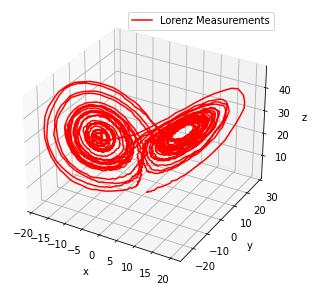

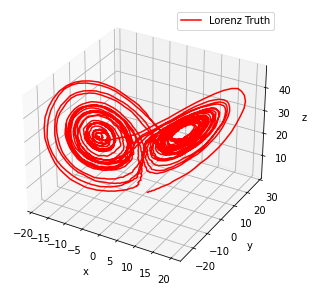

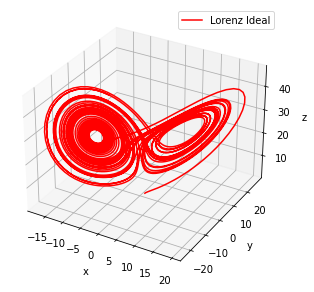



EnKF prediction using (x) measurements:


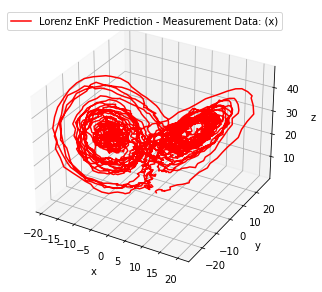

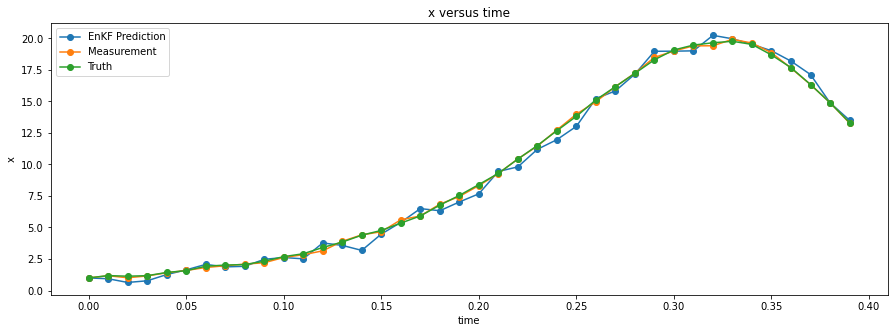

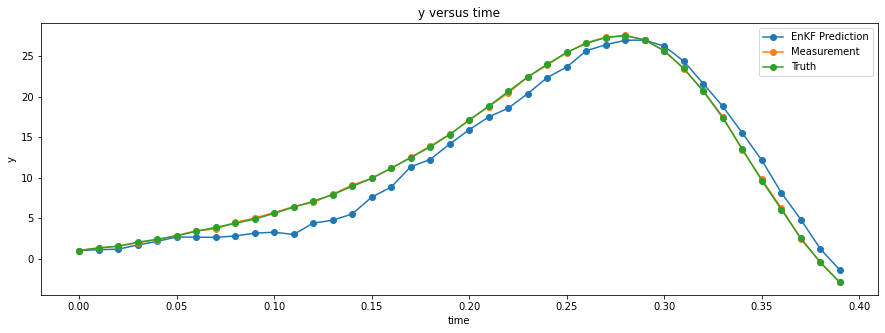

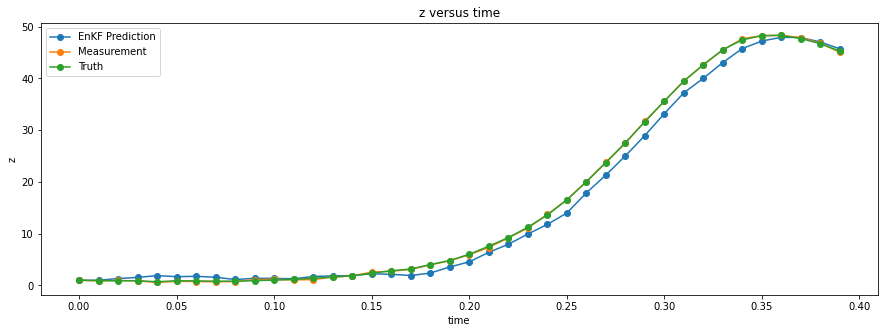

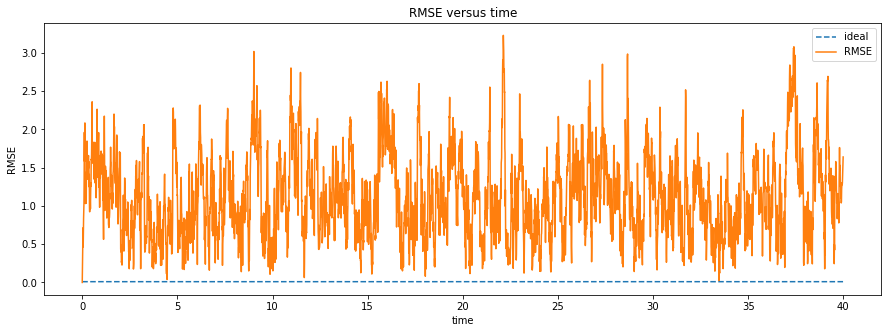

x error (RMSE): 0.45895257957004015
y error (RMSE): 1.437750265497146
z error (RMSE): 1.5392571961748296
total error (RMSE): 1.2445984643258914


EnKF prediction using (y) measurements:


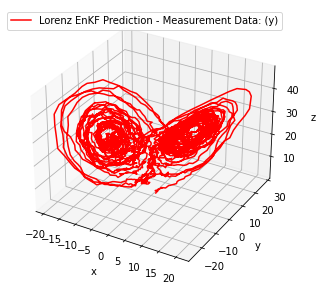

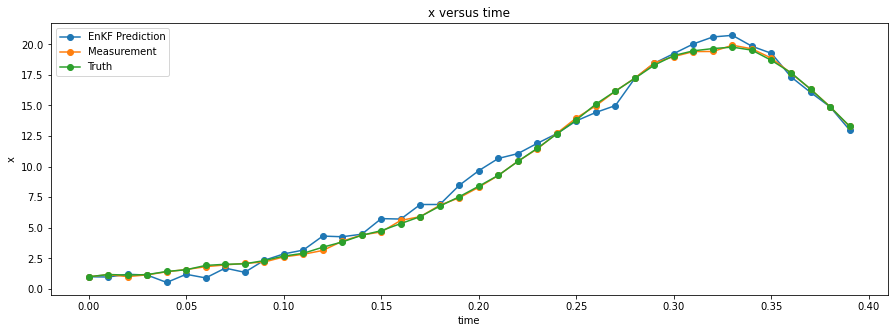

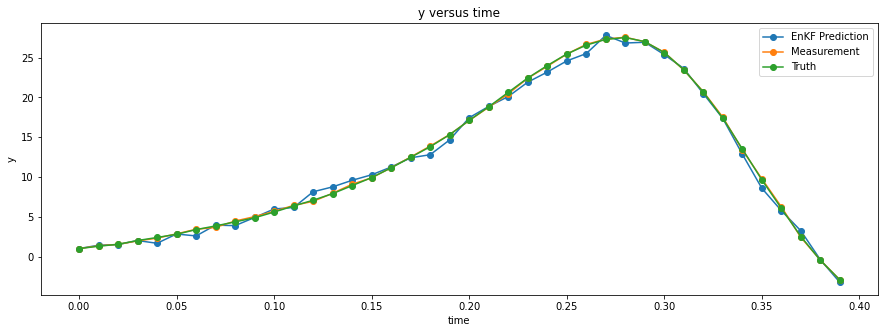

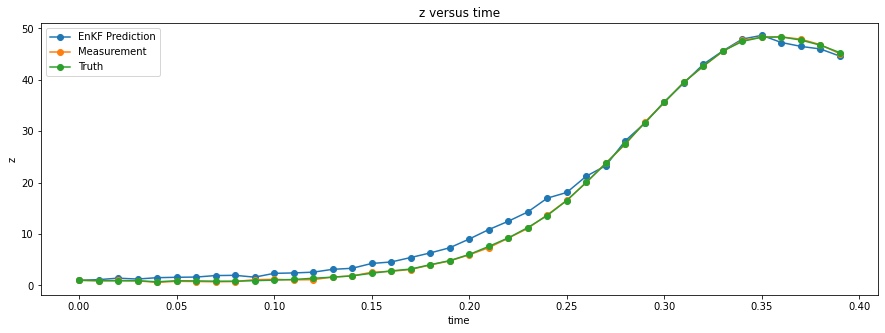

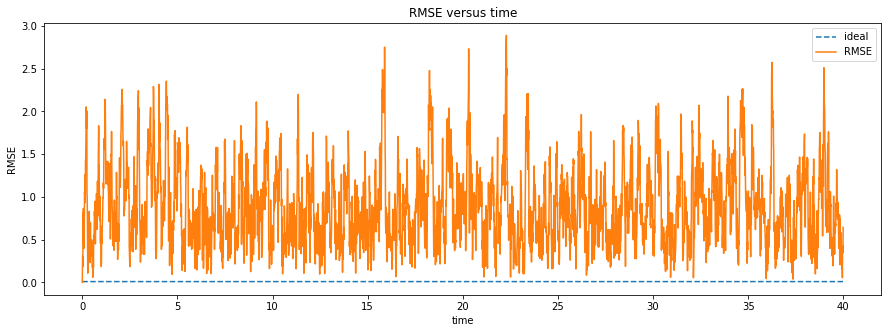

x error (RMSE): 0.8385472136215643
y error (RMSE): 0.47939343145779423
z error (RMSE): 1.4308352440774021
total error (RMSE): 0.9967060729040442


EnKF prediction using (z) measurements:


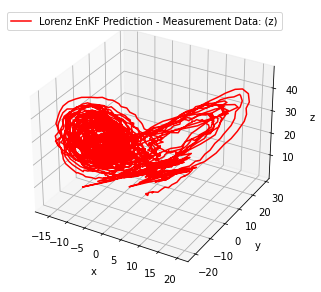

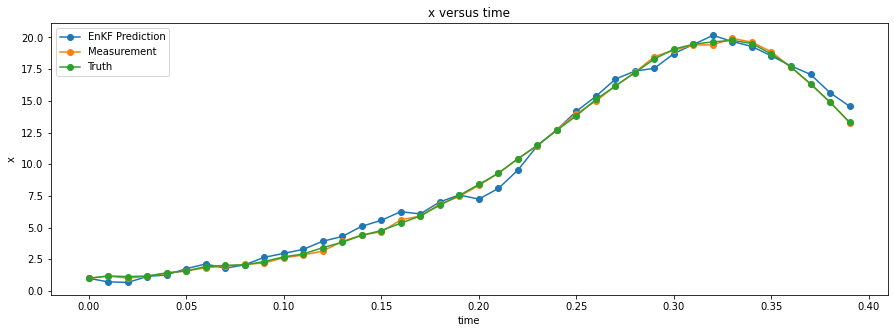

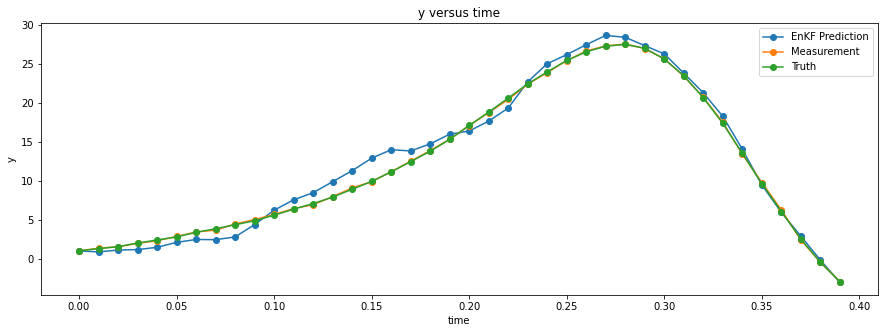

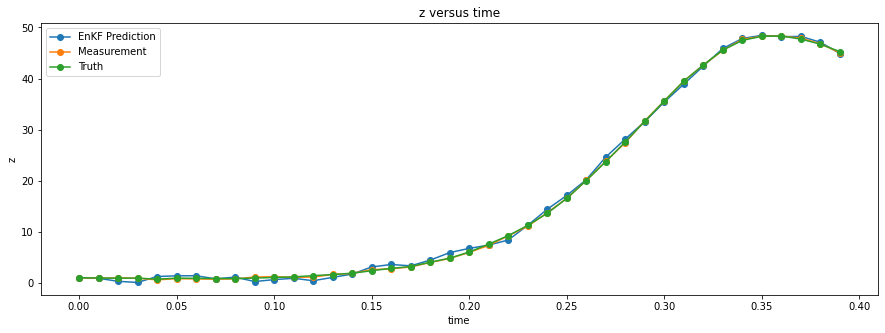

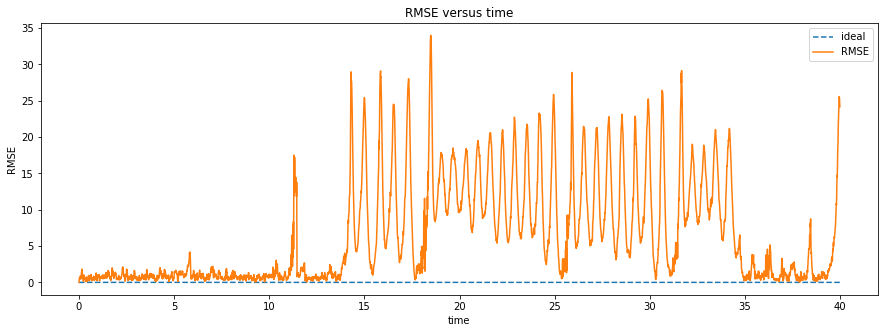

x error (RMSE): 11.441519665673331
y error (RMSE): 12.545031181185722
z error (RMSE): 0.6213921636155602
total error (RMSE): 9.809388492967928


EnKF prediction using (x,y) measurements:


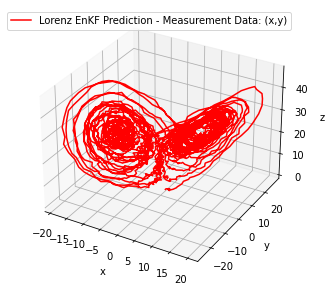

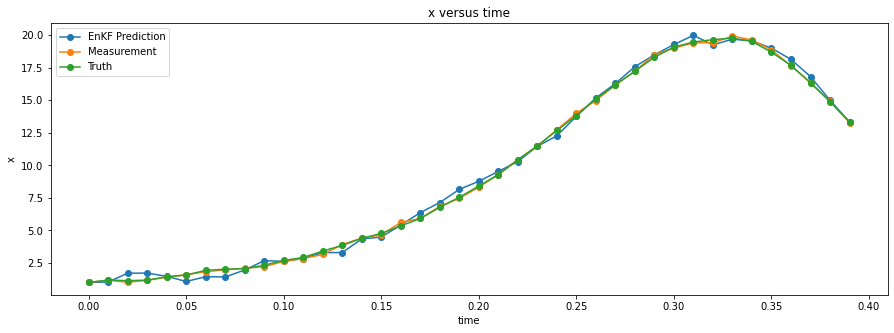

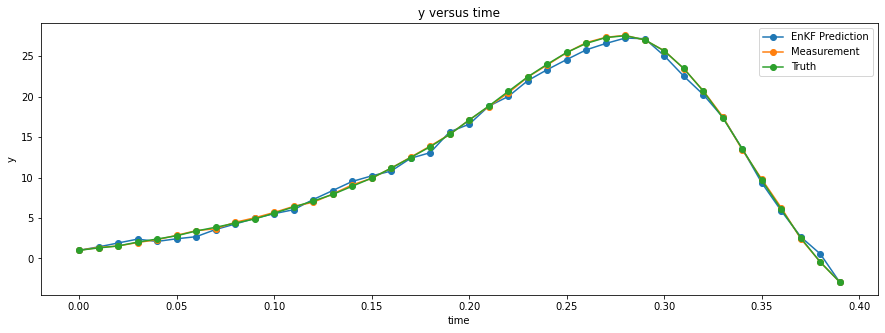

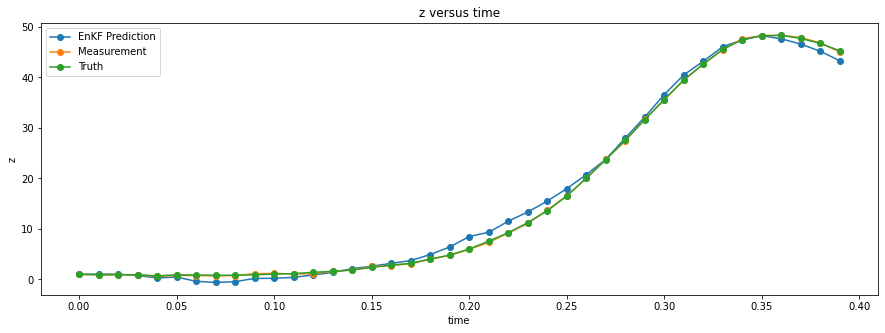

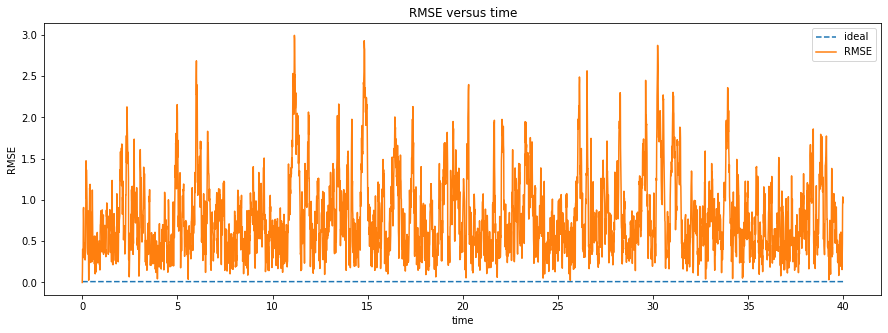

x error (RMSE): 0.3998163742104675
y error (RMSE): 0.46287121172775125
z error (RMSE): 1.4549317527316683
total error (RMSE): 0.9112133480219228


EnKF prediction using (x,z) measurements:


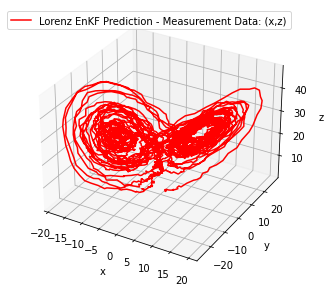

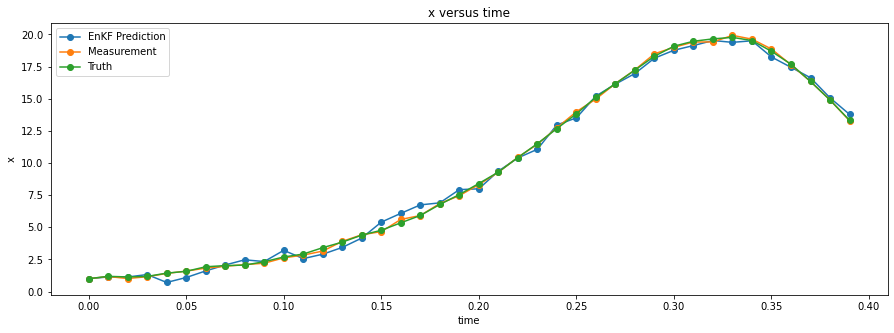

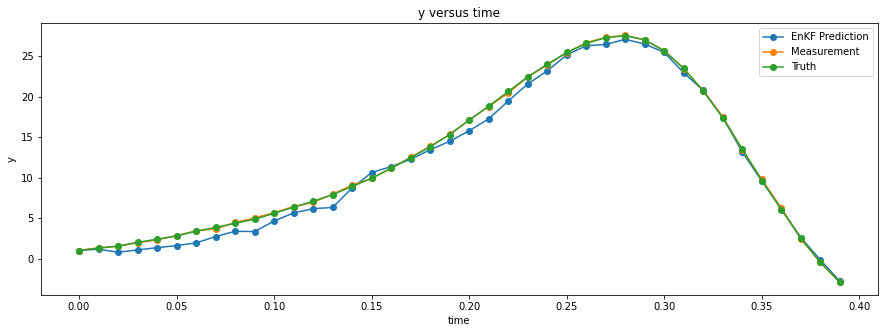

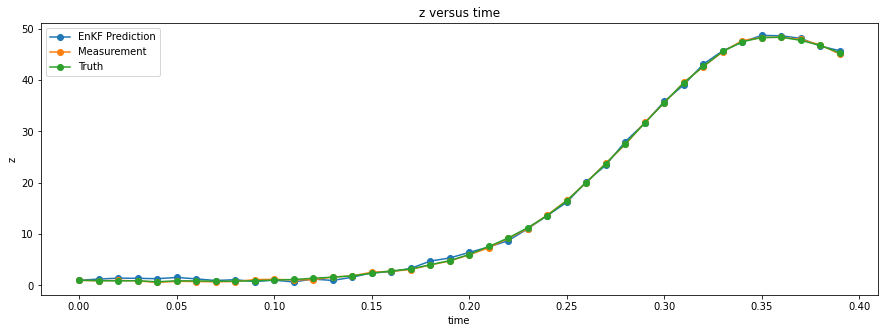

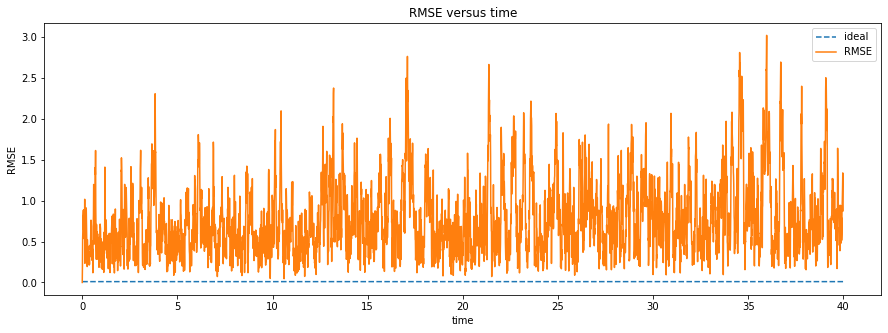

x error (RMSE): 0.4611083441070178
y error (RMSE): 1.4080104041545332
z error (RMSE): 0.45808834164923157
total error (RMSE): 0.8953507938172376


EnKF prediction using (y,z) measurements:


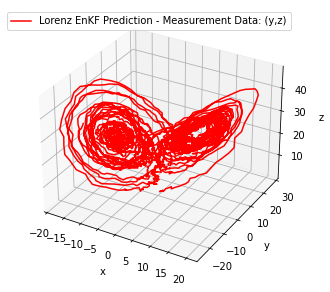

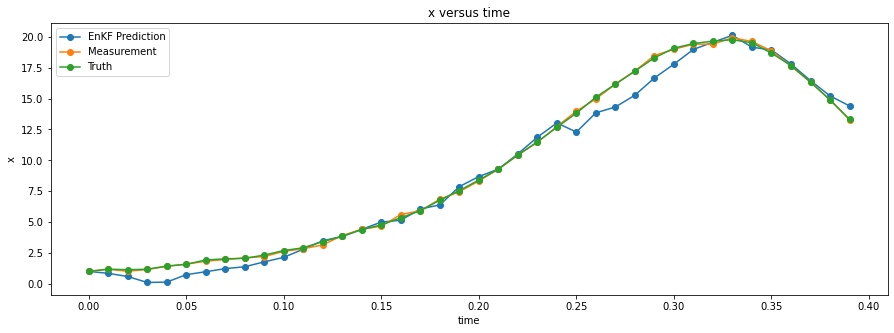

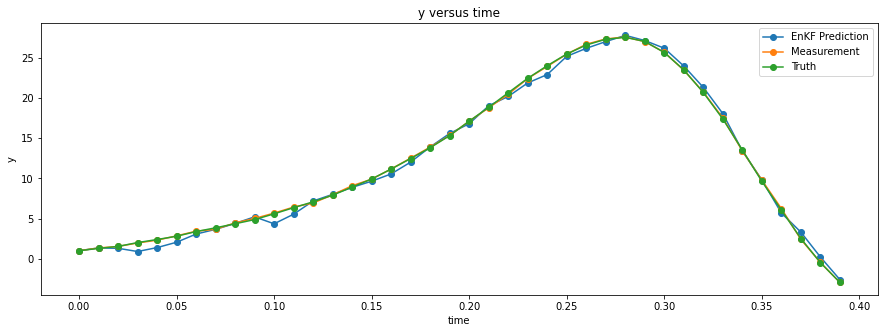

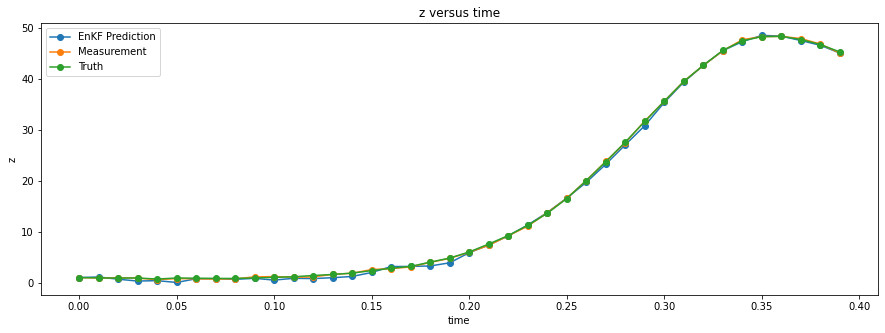

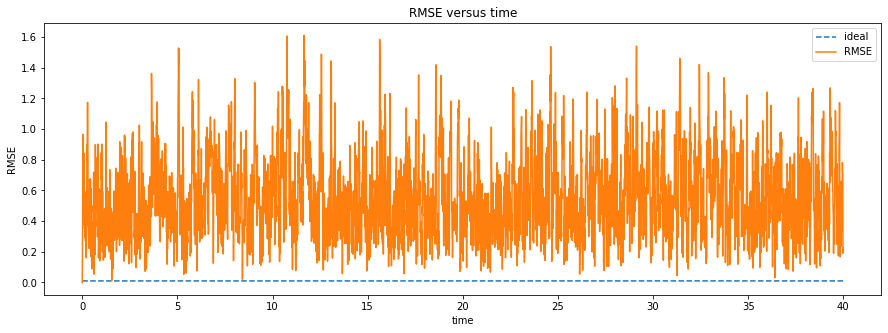

x error (RMSE): 0.8584637083006551
y error (RMSE): 0.447682965061302
z error (RMSE): 0.43508279831383856
total error (RMSE): 0.6128286919588511


EnKF prediction using (x,y,z) measurements:


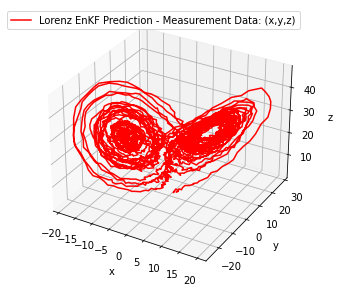

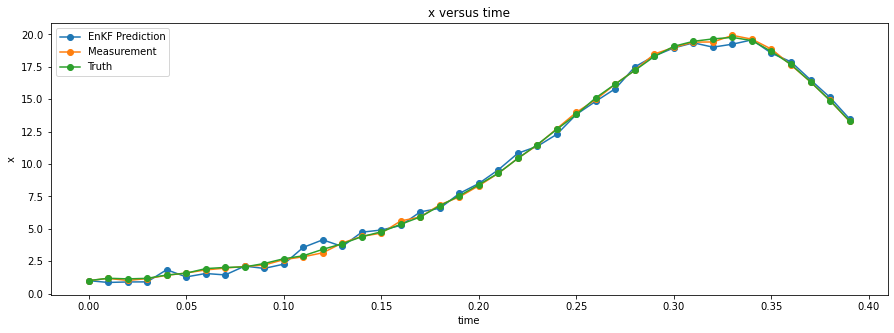

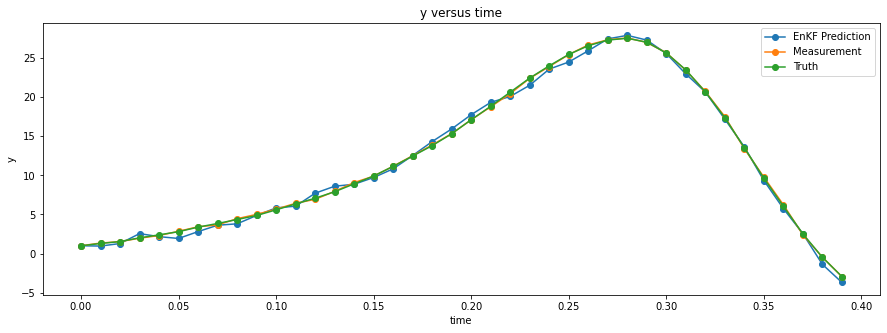

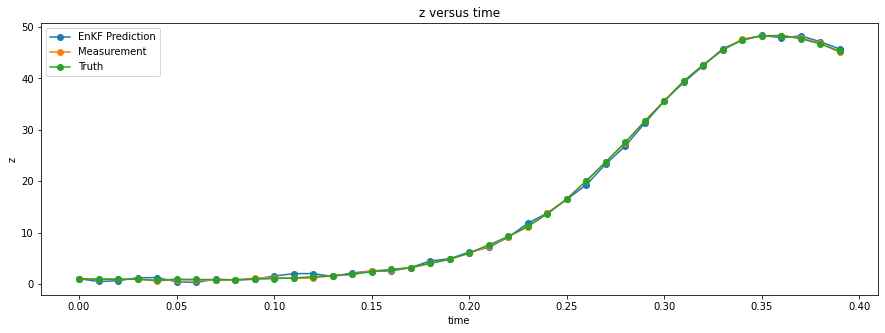

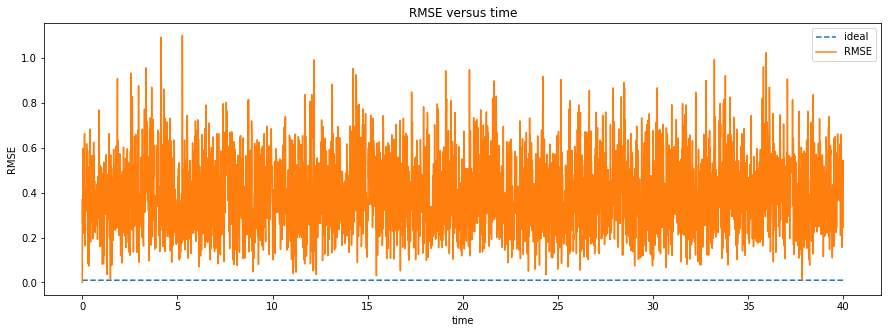

x error (RMSE): 0.42027870854774263
y error (RMSE): 0.43157846561494856
z error (RMSE): 0.4312528071399287
total error (RMSE): 0.4277355680429909


In [45]:
print("Lorenz System Generated Data:")
plot_3d_matrix(X_measurement, 'Lorenz Measurements')
plot_3d_matrix(X_truth, 'Lorenz Truth')
plot_3d_matrix(X_ideal, 'Lorenz Ideal')

errors = []
for X_enkf, measurement_label in zip(enkf_results, measurement_labels):
    print(f"\n\nEnKF prediction using ({measurement_label}) measurements:")
    plot_3d_matrix(X_enkf, f'Lorenz EnKF Prediction - Measurement Data: ({measurement_label})')
    plot_prediction_axes(X_enkf, 0, 40)
    plot_rmse_vs_time(X_enkf)

    # compute errors
    err_lbls = ['x', 'y', 'z', 'total']
    errs = [ rmse(X_truth[:,i], X_enkf[:,i]) for i in range (0,3) ] + [ rmse(X_truth, X_enkf) ]
    errors.append(errs)

    for err, err_lbl in zip(errs, err_lbls):
        print(f"{err_lbl} error (RMSE): {err}")

In [46]:
error_summary = pd.DataFrame(errors, index=np.array(measurement_labels), columns=[ f"{lbl} error (RMSE)" for lbl in ['x', 'y', 'z', 'total'] ])
error_summary

,x error (RMSE),y error (RMSE),z error (RMSE),total error (RMSE)
x,0.458953,1.437750,1.539257,1.244598
y,0.838547,0.479393,1.430835,0.996706
z,11.441520,12.545031,0.621392,9.809388
"x,y",0.399816,0.462871,1.454932,0.911213
"x,z",0.461108,1.408010,0.458088,0.895351
"y,z",0.858464,0.447683,0.435083,0.612829
"x,y,z",0.420279,0.431578,0.431253,0.427736
